# MIMIC-IV AKI Clustering: Unsupervised Phenotype Discovery

**Purpose**: Identify 3-4 distinct AKI phenotypes using multiple clustering algorithms

**Input**: `output/aki_clustering_ready.csv` (from preprocessing notebook)

**Output**: Cluster assignments, validation metrics, clinical characterization

**Clustering Methods**:
1. K-Means
2. Hierarchical Clustering
3. Gaussian Mixture Models (GMM)
4. DBSCAN (density-based)

**Validation**:
- Silhouette score
- Davies-Bouldin index
- Calinski-Harabasz score
- Clinical interpretability

## 1. Setup & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import silhouette_samples
import umap
import warnings
warnings.filterwarnings('ignore')

# Plotting setup
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

DATA_DIR = "./clustering_output/data"
RESULT_DIR = "./clustering_output/result"
print("✓ Libraries loaded")

# Load preprocessed data
print("Loading preprocessed clustering data...")
X = pd.read_csv(f"{DATA_DIR}/aki_clustering_ready.csv")
ids = pd.read_csv(f"{DATA_DIR}/patient_identifiers.csv")
metadata = pd.read_csv(f"{DATA_DIR}/feature_metadata.csv")

print(f"\n📊 Dataset:")
print(f"   Patients: {len(X):,}")
print(f"   Features: {X.shape[1]}")
print(f"   AKI Stage distribution:")
print(ids['aki_stage'].value_counts().sort_index())

/Users/zz005/sepsis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✓ Libraries loaded
Loading preprocessed clustering data...

📊 Dataset:
   Patients: 15,394
   Features: 110
   AKI Stage distribution:
aki_stage
1    8461
2    1774
3    5159
Name: count, dtype: int64


## 2. Dimensionality Reduction and Visualization


🔍 DIMENSIONALITY REDUCTION

1. Principal Component Analysis (PCA)...
   Components explaining 90% variance: 6
   Components explaining 95% variance: 11
   ✓ PCA complete - first 3 PCs explain 81.2% variance
      PC1: 52.8%
      PC2: 17.8%
      PC3: 10.6%

2. UMAP (Uniform Manifold Approximation)...
   ✓ UMAP complete (3 components)

📊 Visualizing PCA embeddings...


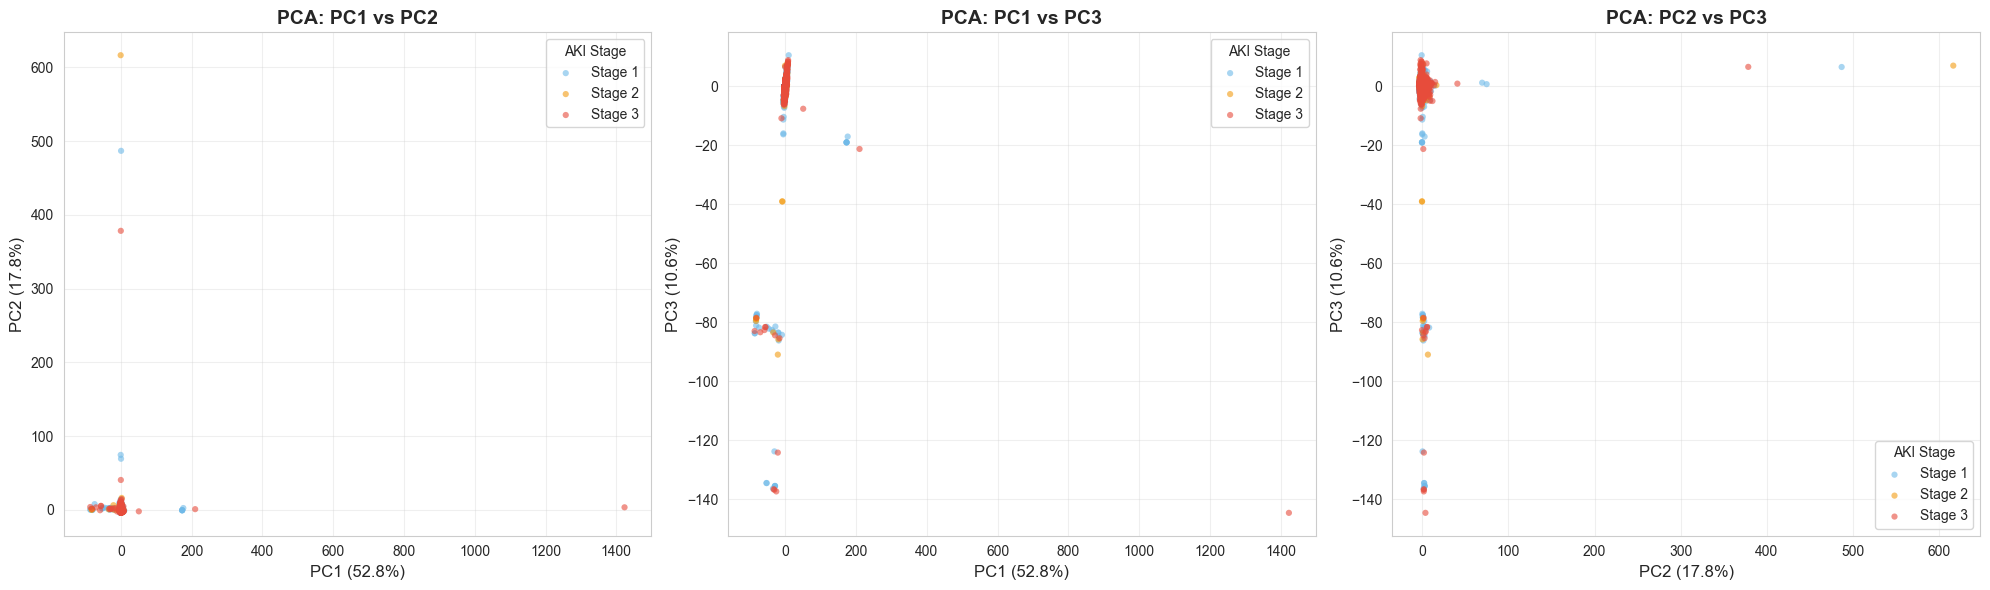

✓ Saved: ./clustering_output/result/pca_embeddings_3views.png

📊 Visualizing UMAP embeddings...


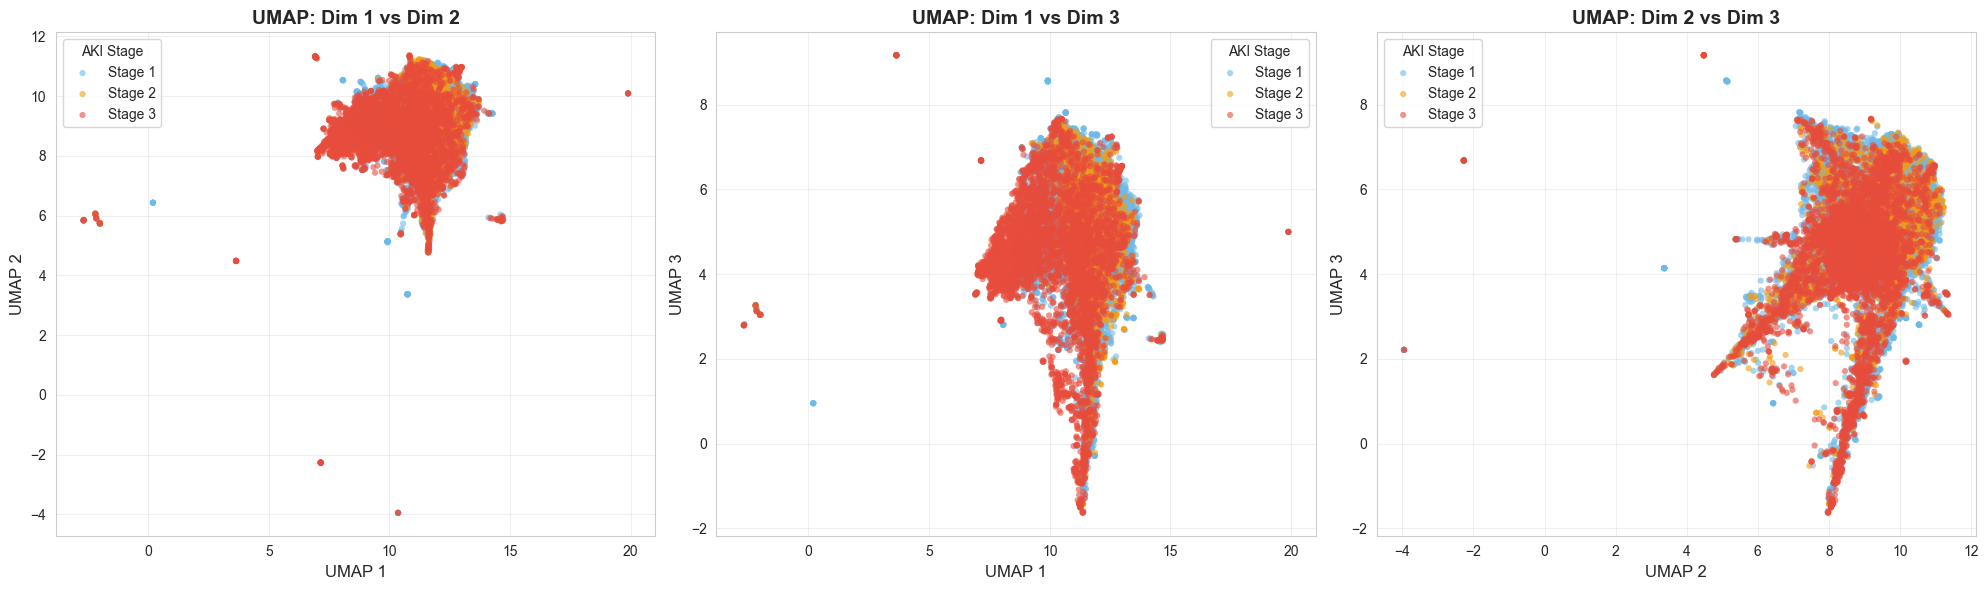

✓ Saved: ./clustering_output/result/umap_embeddings_3views.png

📋 Visual Separation Assessment:
   Look for clear clustering by AKI stage:
   - Clear separation → Stage-driven structure
   - Overlapping → Mixed severity phenotypes
   - Random scatter → Weak stage relationship


In [2]:
print("\n🔍 DIMENSIONALITY REDUCTION\n" + "="*60)

# PCA for variance explanation
print("\n1. Principal Component Analysis (PCA)...")
pca = PCA(n_components=min(50, X.shape[1]))
X_pca = pca.fit_transform(X)

# Explained variance
cumvar = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumvar >= 0.90) + 1
print(f"   Components explaining 90% variance: {n_components_90}")
print(f"   Components explaining 95% variance: {np.argmax(cumvar >= 0.95) + 1}")

# PCA first 3 components for visualization
X_pca_3d = X_pca[:, :3]
print(f"   ✓ PCA complete - first 3 PCs explain {cumvar[2]*100:.1f}% variance")
print(f"      PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"      PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")
print(f"      PC3: {pca.explained_variance_ratio_[2]*100:.1f}%")


# UMAP for better visualization (3D)

print("\n2. UMAP (Uniform Manifold Approximation)...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=3, random_state=42)
X_umap = reducer.fit_transform(X)
print("   ✓ UMAP complete (3 components)")


# Visualize pre-clustering embeddings - PCA
print("\n📊 Visualizing PCA embeddings...")

# Create discrete colormap for AKI stages
aki_stage_colors = {1: "#6eb9e8", 2: '#f39c12', 3: '#e74c3c'} 
stage_labels = {1: 'Stage 1', 2: 'Stage 2', 3: 'Stage 3'}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# PC1 vs PC2
for stage in [1, 2, 3]:
    mask = ids['aki_stage'] == stage
    axes[0].scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 1], 
                    c=aki_stage_colors[stage], label=stage_labels[stage],
                    alpha=0.6, s=20, edgecolors='none')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[0].set_title('PCA: PC1 vs PC2', fontweight='bold', fontsize=14)
axes[0].legend(title='AKI Stage', loc='best')
axes[0].grid(True, alpha=0.3)

# PC1 vs PC3
for stage in [1, 2, 3]:
    mask = ids['aki_stage'] == stage
    axes[1].scatter(X_pca_3d[mask, 0], X_pca_3d[mask, 2], 
                    c=aki_stage_colors[stage], label=stage_labels[stage],
                    alpha=0.6, s=20, edgecolors='none')
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
axes[1].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=12)
axes[1].set_title('PCA: PC1 vs PC3', fontweight='bold', fontsize=14)
axes[1].legend(title='AKI Stage', loc='best')
axes[1].grid(True, alpha=0.3)

# PC2 vs PC3
for stage in [1, 2, 3]:
    mask = ids['aki_stage'] == stage
    axes[2].scatter(X_pca_3d[mask, 1], X_pca_3d[mask, 2], 
                    c=aki_stage_colors[stage], label=stage_labels[stage],
                    alpha=0.6, s=20, edgecolors='none')
axes[2].set_xlabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
axes[2].set_ylabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=12)
axes[2].set_title('PCA: PC2 vs PC3', fontweight='bold', fontsize=14)
axes[2].legend(title='AKI Stage', loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/pca_embeddings_3views.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {RESULT_DIR}/pca_embeddings_3views.png")


# Visualize pre-clustering embeddings - UMAP
if X_umap is not None:
    print("\n📊 Visualizing UMAP embeddings...")
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # UMAP1 vs UMAP2
    for stage in [1, 2, 3]:
        mask = ids['aki_stage'] == stage
        axes[0].scatter(X_umap[mask, 0], X_umap[mask, 1], 
                        c=aki_stage_colors[stage], label=stage_labels[stage],
                        alpha=0.6, s=20, edgecolors='none')
    axes[0].set_xlabel('UMAP 1', fontsize=12)
    axes[0].set_ylabel('UMAP 2', fontsize=12)
    axes[0].set_title('UMAP: Dim 1 vs Dim 2', fontweight='bold', fontsize=14)
    axes[0].legend(title='AKI Stage', loc='best')
    axes[0].grid(True, alpha=0.3)
    
    # UMAP1 vs UMAP3
    for stage in [1, 2, 3]:
        mask = ids['aki_stage'] == stage
        axes[1].scatter(X_umap[mask, 0], X_umap[mask, 2], 
                        c=aki_stage_colors[stage], label=stage_labels[stage],
                        alpha=0.6, s=20, edgecolors='none')
    axes[1].set_xlabel('UMAP 1', fontsize=12)
    axes[1].set_ylabel('UMAP 3', fontsize=12)
    axes[1].set_title('UMAP: Dim 1 vs Dim 3', fontweight='bold', fontsize=14)
    axes[1].legend(title='AKI Stage', loc='best')
    axes[1].grid(True, alpha=0.3)
    
    # UMAP2 vs UMAP3
    for stage in [1, 2, 3]:
        mask = ids['aki_stage'] == stage
        axes[2].scatter(X_umap[mask, 1], X_umap[mask, 2], 
                        c=aki_stage_colors[stage], label=stage_labels[stage],
                        alpha=0.6, s=20, edgecolors='none')
    axes[2].set_xlabel('UMAP 2', fontsize=12)
    axes[2].set_ylabel('UMAP 3', fontsize=12)
    axes[2].set_title('UMAP: Dim 2 vs Dim 3', fontweight='bold', fontsize=14)
    axes[2].legend(title='AKI Stage', loc='best')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{RESULT_DIR}/umap_embeddings_3views.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved: {RESULT_DIR}/umap_embeddings_3views.png")
else:
    print("\n⚠ UMAP visualization skipped (UMAP not available)")


# Summary of separation
print("\n📋 Visual Separation Assessment:")
print("   Look for clear clustering by AKI stage:")
print("   - Clear separation → Stage-driven structure")
print("   - Overlapping → Mixed severity phenotypes")
print("   - Random scatter → Weak stage relationship")

## 3. Test Optimal Number of Clusters


🎯 Test Optimal Number of Clusters

💡 Strategy: Using PCA-reduced data for clustering
   Original dimensions: 110
   PCA components (90% variance): 6
   This helps avoid curse of dimensionality and improves cluster quality

✓ Using 6 PCA components for clustering

Testing K-Means for k = 2 to 8 (on PCA data)...
  k=2... Silhouette: 0.996, Sizes: [15393, 1], Max: 100.0%
  k=3... Silhouette: 0.990, Sizes: [15390, 1, 3], Max: 100.0%
  k=4... Silhouette: 0.955, Sizes: [15344, 1, 3, 46], Max: 99.7%
  k=5... Silhouette: 0.955, Sizes: [15344, 1, 2, 46, 1], Max: 99.7%
  k=6... Silhouette: 0.956, Sizes: [15338, 2, 1, 6, 1, 46], Max: 99.6%
  k=7... Silhouette: 0.532, Sizes: [13877, 46, 1, 2, 1461, 1, 6], Max: 90.1%
  k=8... Silhouette: 0.526, Sizes: [1541, 1, 2, 46, 13795, 1, 6, 2], Max: 89.6%

✓ Metrics calculated for all k values


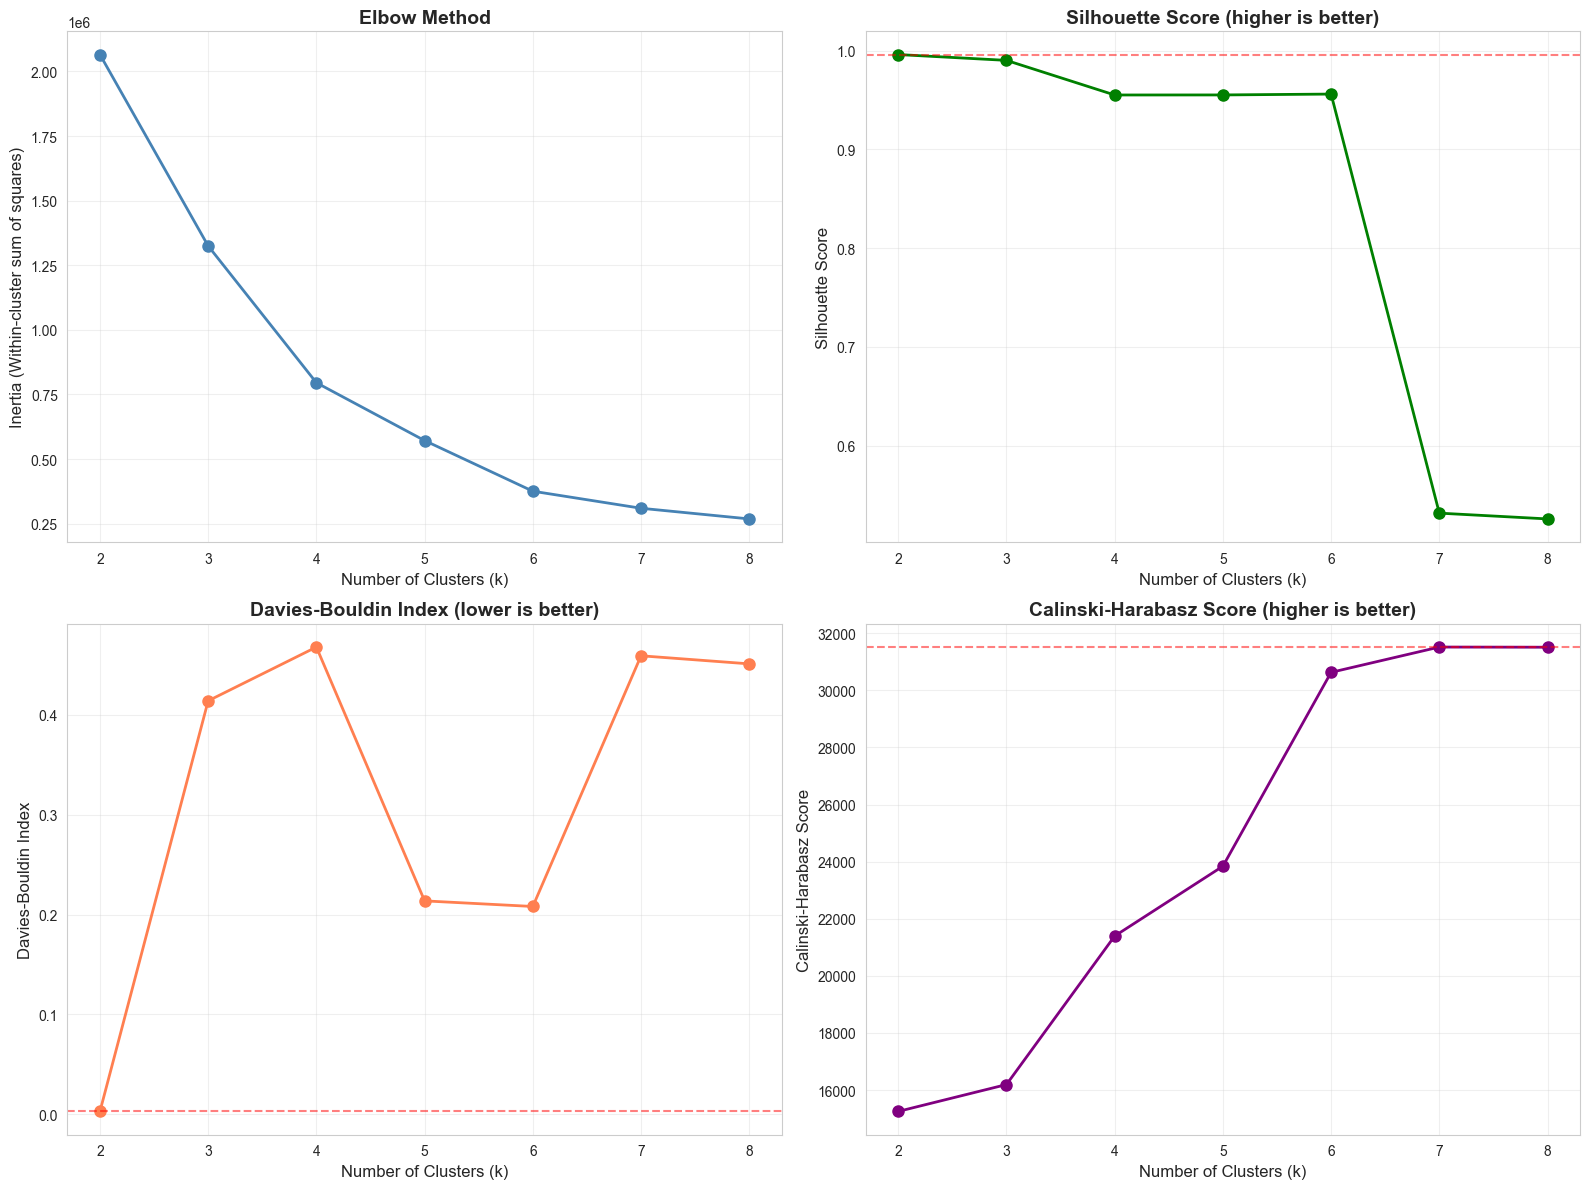


✓ Saved: ./clustering_output/result/optimal_k_analysis.png

📊 OPTIMAL K RECOMMENDATION:

Best k by Silhouette Score:        2
Best k by Davies-Bouldin Index:    2
Best k by Calinski-Harabasz:       7

🎯 CONSENSUS RECOMMENDATION: k = 2
   (Based on majority voting across metrics)


In [3]:
print("\n🎯 Test Optimal Number of Clusters\n" + "="*60)

# IMPORTANT: Use PCA-reduced data for clustering to avoid curse of dimensionality
print(f"\n💡 Strategy: Using PCA-reduced data for clustering")
print(f"   Original dimensions: {X.shape[1]}")
print(f"   PCA components (90% variance): {n_components_90}")
print(f"   This helps avoid curse of dimensionality and improves cluster quality\n")

# Use PCA components that explain 90% of variance
X_for_clustering = X_pca[:, :n_components_90]
print(f"✓ Using {X_for_clustering.shape[1]} PCA components for clustering\n")

# Test k=2 to k=8
K_RANGE = range(2, 9)
metrics = {
    'k': [],
    'inertia': [],
    'silhouette': [],
    'davies_bouldin': [],
    'calinski_harabasz': []
}

print("Testing K-Means for k = 2 to 8 (on PCA data)...")
for k in K_RANGE:
    print(f"  k={k}...", end=' ')
    
    # Fit K-Means on PCA data
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=500)
    labels = kmeans.fit_predict(X_for_clustering)
    
    # Check for degenerate clustering (one cluster > 95%)
    sizes = np.bincount(labels)
    max_size_pct = sizes.max() / len(labels) * 100
    
    # Calculate metrics
    metrics['k'].append(k)
    metrics['inertia'].append(kmeans.inertia_)
    metrics['silhouette'].append(silhouette_score(X_for_clustering, labels))
    metrics['davies_bouldin'].append(davies_bouldin_score(X_for_clustering, labels))
    metrics['calinski_harabasz'].append(calinski_harabasz_score(X_for_clustering, labels))
    
    print(f"Silhouette: {metrics['silhouette'][-1]:.3f}, Sizes: {sizes.tolist()}, Max: {max_size_pct:.1f}%")

metrics_df = pd.DataFrame(metrics)
print("\n✓ Metrics calculated for all k values")


# Visualize metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Elbow plot (inertia)
axes[0, 0].plot(metrics_df['k'], metrics_df['inertia'], 'o-', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
axes[0, 0].set_title('Elbow Method', fontweight='bold', fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

# Silhouette score (higher is better)
axes[0, 1].plot(metrics_df['k'], metrics_df['silhouette'], 'o-', linewidth=2, markersize=8, color='green')
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Score (higher is better)', fontweight='bold', fontsize=14)
axes[0, 1].axhline(y=metrics_df['silhouette'].max(), color='red', linestyle='--', alpha=0.5)
axes[0, 1].grid(True, alpha=0.3)

# Davies-Bouldin index (lower is better)
axes[1, 0].plot(metrics_df['k'], metrics_df['davies_bouldin'], 'o-', linewidth=2, markersize=8, color='coral')
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1, 0].set_title('Davies-Bouldin Index (lower is better)', fontweight='bold', fontsize=14)
axes[1, 0].axhline(y=metrics_df['davies_bouldin'].min(), color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(True, alpha=0.3)

# Calinski-Harabasz score (higher is better)
axes[1, 1].plot(metrics_df['k'], metrics_df['calinski_harabasz'], 'o-', linewidth=2, markersize=8, color='purple')
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 1].set_title('Calinski-Harabasz Score (higher is better)', fontweight='bold', fontsize=14)
axes[1, 1].axhline(y=metrics_df['calinski_harabasz'].max(), color='red', linestyle='--', alpha=0.5)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/optimal_k_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {RESULT_DIR}/optimal_k_analysis.png")


# Recommend optimal k
print("\n📊 OPTIMAL K RECOMMENDATION:")
print("="*60)

best_silhouette_k = metrics_df.loc[metrics_df['silhouette'].idxmax(), 'k']
best_db_k = metrics_df.loc[metrics_df['davies_bouldin'].idxmin(), 'k']
best_ch_k = metrics_df.loc[metrics_df['calinski_harabasz'].idxmax(), 'k']

print(f"\nBest k by Silhouette Score:        {int(best_silhouette_k)}")
print(f"Best k by Davies-Bouldin Index:    {int(best_db_k)}")
print(f"Best k by Calinski-Harabasz:       {int(best_ch_k)}")

# Consensus recommendation
from collections import Counter
votes = [best_silhouette_k, best_db_k, best_ch_k]
consensus = Counter(votes).most_common(1)[0][0]

print(f"\n🎯 CONSENSUS RECOMMENDATION: k = {int(consensus)}")
print(f"   (Based on majority voting across metrics)")

## 4. Clustering

In [4]:
# meaningful clusters start showing up at k6
OPTIMAL_K = 6
print(f"\n🔬 Applying clustering algorithms (k={OPTIMAL_K})\n" + "="*60)
print(f"Using PCA-reduced data ({X_for_clustering.shape[1]} components)\n")

# Dictionary to store all clustering results
clustering_results = {}

# 1. K-Means
print(f"\n1. K-Means Clustering (k={OPTIMAL_K})...")
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=50, max_iter=1000)
labels_kmeans = kmeans.fit_predict(X_for_clustering)
clustering_results['kmeans'] = labels_kmeans

sil_kmeans = silhouette_score(X_for_clustering, labels_kmeans)
db_kmeans = davies_bouldin_score(X_for_clustering, labels_kmeans)
ch_kmeans = calinski_harabasz_score(X_for_clustering, labels_kmeans)

cluster_sizes = np.bincount(labels_kmeans)
print(f"   ✓ Silhouette: {sil_kmeans:.3f}")
print(f"   ✓ Davies-Bouldin: {db_kmeans:.3f}")
print(f"   ✓ Calinski-Harabasz: {ch_kmeans:.1f}")
print(f"   ✓ Cluster sizes: {cluster_sizes.tolist()}")
print(f"   ✓ Size percentages: {(cluster_sizes / len(labels_kmeans) * 100).round(1).tolist()}%")

# Check for degenerate clustering
max_cluster_pct = cluster_sizes.max() / len(labels_kmeans) * 100
if max_cluster_pct > 90:
    print(f"   ⚠ WARNING: Dominant cluster detected ({max_cluster_pct:.1f}%)")
    print(f"      This suggests weak cluster structure. Consider:")
    print(f"      - Using fewer clusters (k=2 or k=3)")
    print(f"      - AKI may exist on a continuum rather than discrete subtypes")
    print(f"      - Try alternative approaches (e.g., severity-based stratification)")


# 2. Hierarchical Clustering (Ward linkage)
print(f"\n2. Hierarchical Clustering (Ward, k={OPTIMAL_K})...")
hierarchical = AgglomerativeClustering(n_clusters=OPTIMAL_K, linkage='ward')
labels_hierarchical = hierarchical.fit_predict(X_for_clustering)
clustering_results['hierarchical'] = labels_hierarchical

sil_hier = silhouette_score(X_for_clustering, labels_hierarchical)
db_hier = davies_bouldin_score(X_for_clustering, labels_hierarchical)
ch_hier = calinski_harabasz_score(X_for_clustering, labels_hierarchical)

cluster_sizes_hier = np.bincount(labels_hierarchical)
print(f"   ✓ Silhouette: {sil_hier:.3f}")
print(f"   ✓ Davies-Bouldin: {db_hier:.3f}")
print(f"   ✓ Calinski-Harabasz: {ch_hier:.1f}")
print(f"   ✓ Cluster sizes: {cluster_sizes_hier.tolist()}")
print(f"   ✓ Size percentages: {(cluster_sizes_hier / len(labels_hierarchical) * 100).round(1).tolist()}%")


# 3. Gaussian Mixture Model
print(f"\n3. Gaussian Mixture Model (k={OPTIMAL_K})...")
gmm = GaussianMixture(n_components=OPTIMAL_K, random_state=42, n_init=20, max_iter=300, 
                      covariance_type='full')
labels_gmm = gmm.fit_predict(X_for_clustering)
clustering_results['gmm'] = labels_gmm

# Get probabilities for soft clustering
probs_gmm = gmm.predict_proba(X_for_clustering)
max_probs = probs_gmm.max(axis=1)

sil_gmm = silhouette_score(X_for_clustering, labels_gmm)
db_gmm = davies_bouldin_score(X_for_clustering, labels_gmm)
ch_gmm = calinski_harabasz_score(X_for_clustering, labels_gmm)

cluster_sizes_gmm = np.bincount(labels_gmm)
print(f"   ✓ Silhouette: {sil_gmm:.3f}")
print(f"   ✓ Davies-Bouldin: {db_gmm:.3f}")
print(f"   ✓ Calinski-Harabasz: {ch_gmm:.1f}")
print(f"   ✓ Cluster sizes: {cluster_sizes_gmm.tolist()}")
print(f"   ✓ Size percentages: {(cluster_sizes_gmm / len(labels_gmm) * 100).round(1).tolist()}%")
print(f"   ✓ Mean assignment probability: {max_probs.mean():.3f}")
print(f"   ✓ Low confidence assignments (<0.7): {(max_probs < 0.7).sum()} ({(max_probs < 0.7).mean()*100:.1f}%)")

# 4. Alternative: Try k=2 and k=3 if current k shows poor separation
print(f"\n4. Testing Alternative Cluster Numbers...")

alternative_ks = [2, 3] if OPTIMAL_K > 3 else [2]
alternative_results = {}

for k_alt in alternative_ks:
    print(f"\n   Testing k={k_alt}...")
    kmeans_alt = KMeans(n_clusters=k_alt, random_state=42, n_init=50, max_iter=1000)
    labels_alt = kmeans_alt.fit_predict(X_for_clustering)
    
    sil_alt = silhouette_score(X_for_clustering, labels_alt)
    sizes_alt = np.bincount(labels_alt)
    pcts_alt = (sizes_alt / len(labels_alt) * 100).round(1)
    
    alternative_results[k_alt] = {
        'labels': labels_alt,
        'silhouette': sil_alt,
        'sizes': sizes_alt,
        'percentages': pcts_alt
    }
    
    print(f"      Silhouette: {sil_alt:.3f}")
    print(f"      Sizes: {sizes_alt.tolist()} ({pcts_alt.tolist()}%)")
    
    # Check if this is better
    if sil_alt > sil_kmeans and sizes_alt.min() / len(labels_alt) > 0.05:
        print(f"      ✓ k={k_alt} shows BETTER separation than k={OPTIMAL_K}!")

# Assessment and recommendation
print(f"\n{'='*60}")
print("CLUSTERING ASSESSMENT")
print(f"{'='*60}")

# Check if any clustering is degenerate
methods_status = {
    'K-Means': (sil_kmeans, cluster_sizes),
    'Hierarchical': (sil_hier, cluster_sizes_hier),
    'GMM': (sil_gmm, cluster_sizes_gmm)
}

print("\nCluster balance check:")
for method, (sil, sizes) in methods_status.items():
    min_size_pct = sizes.min() / len(labels_kmeans) * 100
    max_size_pct = sizes.max() / len(labels_kmeans) * 100
    
    if max_size_pct > 90:
        status = "❌ POOR (dominant cluster)"
    elif min_size_pct < 5:
        status = "⚠ FAIR (tiny cluster)"
    else:
        status = "✓ GOOD (balanced)"
    
    print(f"   {method:15s}: {status} - Sil={sil:.3f}, Range={min_size_pct:.1f}%-{max_size_pct:.1f}%")

# Recommendation
print(f"\n💡 RECOMMENDATION:")
best_sil = max(sil_kmeans, sil_hier, sil_gmm)

if best_sil < 0.2:
    print("   ⚠ Low silhouette scores (<0.2) suggest weak cluster structure")
    print("   Consider:")
    print("   1. Use k=2 (binary split) - often more robust")
    print("   2. Use AKI stage as primary stratification")
    print("   3. Focus on outcome-based phenotyping instead")
    print("   4. AKI may exist on a continuum, not discrete subtypes")
elif any(sizes.max() / len(labels_kmeans) > 0.90 for sizes in [cluster_sizes, cluster_sizes_hier, cluster_sizes_gmm]):
    print("   ⚠ Dominant cluster detected - consider reducing k")
    print("   Suggestion: Use k=2 or k=3 for more balanced clusters")
else:
    print(f"   ✓ Clustering shows reasonable structure (silhouette={best_sil:.3f})")
    print(f"   ✓ Proceed with k={OPTIMAL_K} for phenotype characterization")


# 4. DBSCAN (density-based) - exploratory
print(f"\n4. DBSCAN (Density-Based)...")
print("   Finding optimal eps parameter...")

# Use k-distance graph to find eps
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=10)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)
distances = np.sort(distances[:, -1], axis=0)

# Use knee point as eps (simplified approach)
eps = np.percentile(distances, 95)
print(f"   Estimated eps: {eps:.3f}")

dbscan = DBSCAN(eps=eps, min_samples=10)
labels_dbscan = dbscan.fit_predict(X)
clustering_results['dbscan'] = labels_dbscan

n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)

print(f"   ✓ Clusters found: {n_clusters_dbscan}")
print(f"   ✓ Noise points: {n_noise} ({n_noise/len(X)*100:.1f}%)")

if n_clusters_dbscan > 1 and n_noise < len(X) * 0.5:
    # Only calculate metrics if we have reasonable clustering
    mask = labels_dbscan != -1
    if mask.sum() > 0:
        sil_dbscan = silhouette_score(X[mask], labels_dbscan[mask])
        print(f"   ✓ Silhouette (excl. noise): {sil_dbscan:.3f}")
else:
    print("   ⚠ DBSCAN found poor clustering - may not be suitable for this data")



🔬 Applying clustering algorithms (k=6)
Using PCA-reduced data (6 components)


1. K-Means Clustering (k=6)...
   ✓ Silhouette: 0.956
   ✓ Davies-Bouldin: 0.208
   ✓ Calinski-Harabasz: 30629.0
   ✓ Cluster sizes: [15338, 2, 1, 6, 1, 46]
   ✓ Size percentages: [99.6, 0.0, 0.0, 0.0, 0.0, 0.3]%
   ⚠ WARNING: Dominant cluster detected (99.6%)
      This suggests weak cluster structure. Consider:
      - Using fewer clusters (k=2 or k=3)
      - AKI may exist on a continuum rather than discrete subtypes
      - Try alternative approaches (e.g., severity-based stratification)

2. Hierarchical Clustering (Ward, k=6)...
   ✓ Silhouette: 0.956
   ✓ Davies-Bouldin: 0.208
   ✓ Calinski-Harabasz: 30629.0
   ✓ Cluster sizes: [15338, 46, 2, 1, 1, 6]
   ✓ Size percentages: [99.6, 0.3, 0.0, 0.0, 0.0, 0.0]%

3. Gaussian Mixture Model (k=6)...
   ✓ Silhouette: 0.321
   ✓ Davies-Bouldin: 1.139
   ✓ Calinski-Harabasz: 10060.7
   ✓ Cluster sizes: [11402, 1, 3736, 2, 1, 252]
   ✓ Size percentages: [74.1, 0.

### 5. Compare Clustering Methods

In [5]:
print("\n📊 Compare Clustering Methods\n" + "="*60)

# Summary table
comparison = pd.DataFrame({
    'Method': ['K-Means', 'Hierarchical', 'GMM'],
    'Silhouette': [sil_kmeans, sil_hier, sil_gmm],
    'Davies-Bouldin': [db_kmeans, db_hier, db_gmm],
    'Calinski-Harabasz': [ch_kmeans, ch_hier, ch_gmm],
    'Cluster_Sizes': [
        str(np.bincount(labels_kmeans).tolist()),
        str(np.bincount(labels_hierarchical).tolist()),
        str(np.bincount(labels_gmm).tolist())
    ]
})

print("\nQuantitative Metrics:")
display(comparison)


📊 Compare Clustering Methods

Quantitative Metrics:


,Method,Silhouette,Davies-Bouldin,Calinski-Harabasz,Cluster_Sizes
0,K-Means,0.955895,0.208054,30628.998363,"[15338, 2, 1, 6, 1, 46]"
1,Hierarchical,0.955895,0.208054,30628.998363,"[15338, 46, 2, 1, 1, 6]"
2,GMM,0.321023,1.139433,10060.729491,"[11402, 1, 3736, 2, 1, 252]"


In [6]:
best_method_name = 'gmm'
labels_final = labels_gmm
selected_clusters = [0,2]

## 6. Visualize Final Clusters


🎨 VISUALIZING FINAL CLUSTERS (GMM)


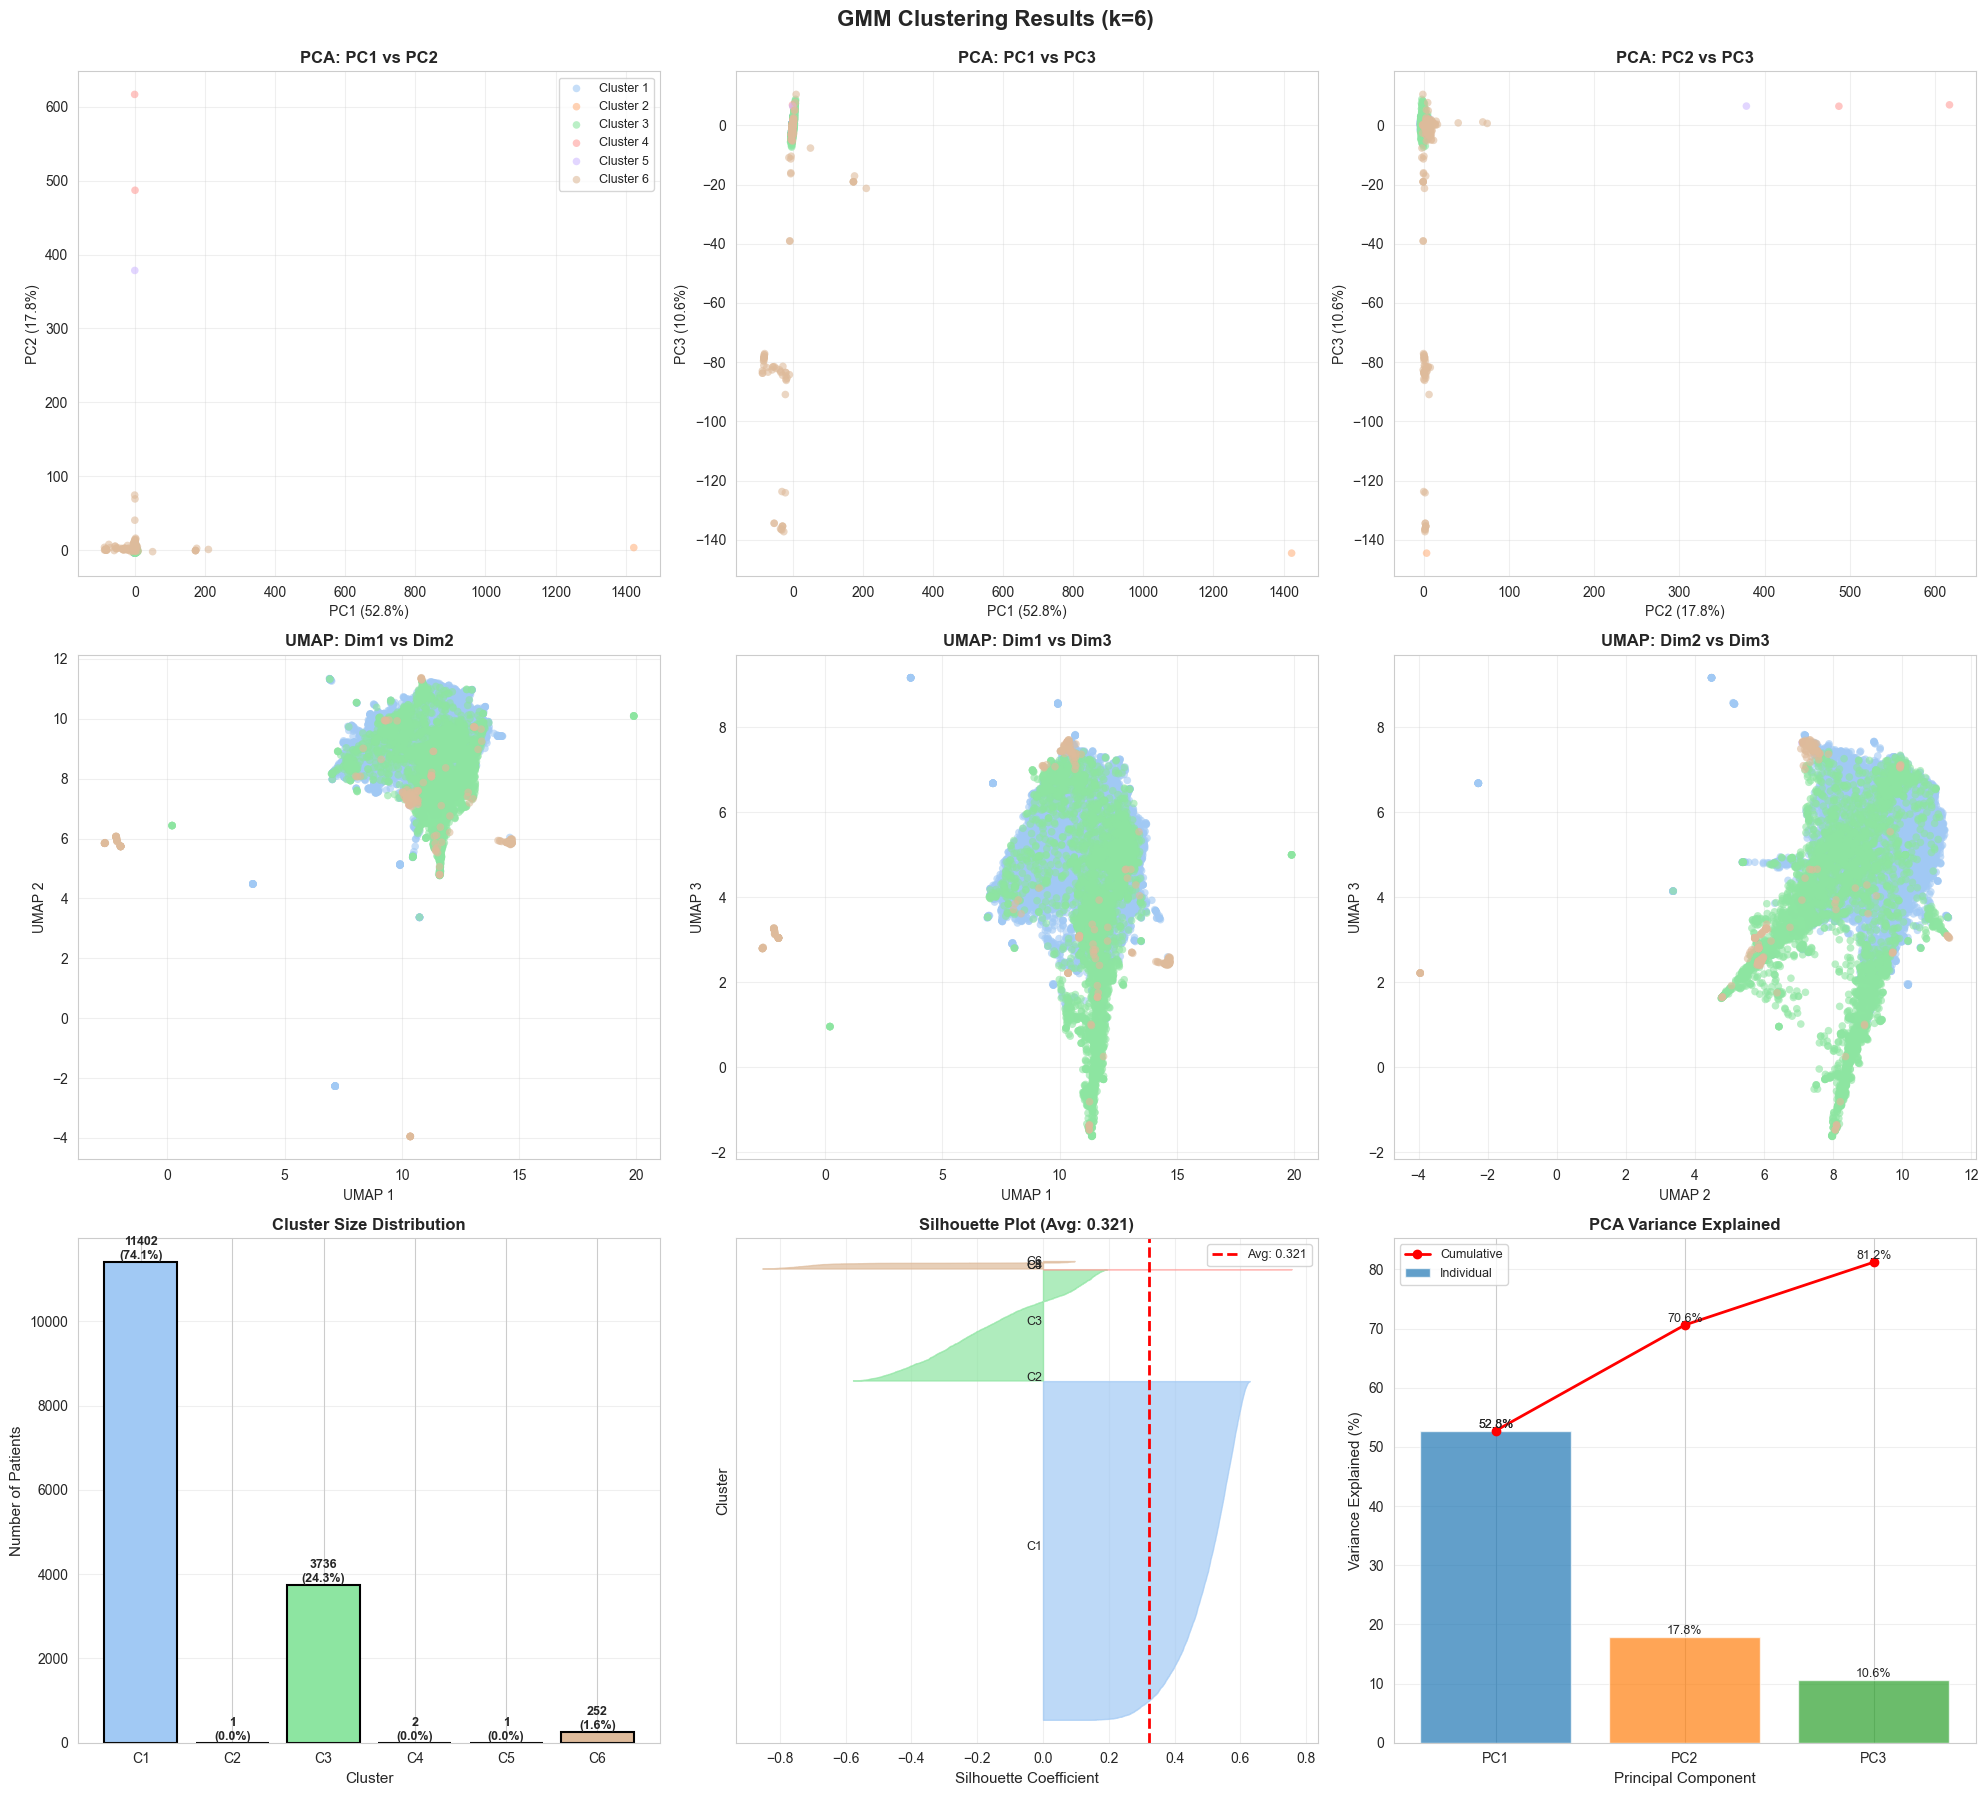

✓ Saved: ./clustering_output/result/final_clusters_3d_visualization.png


In [7]:
print(f"\n🎨 VISUALIZING FINAL CLUSTERS ({best_method_name.upper()})\n" + "="*60)

# Create a 3x3 grid for all combinations
fig, axes = plt.subplots(3, 3, figsize=(20, 18))

# Color palette
colors = sns.color_palette("pastel", OPTIMAL_K)

# Function to plot clusters in 2D projection
def plot_2d_projection(ax, coords_3d, dim1, dim2, labels, colors, title, x_label, y_label):
    """Helper function to plot 2D projections from 3D coordinates"""
    for i in range(OPTIMAL_K):
        mask = labels == i
        ax.scatter(coords_3d[mask, dim1], coords_3d[mask, dim2], 
                   c=[colors[i]], label=f'Cluster {i+1}', 
                   alpha=0.6, s=30, edgecolors='none')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title, fontweight='bold', fontsize=12)
    ax.grid(True, alpha=0.3)

# ============================================================================
# ROW 1: PCA PROJECTIONS (3 combinations)
# ============================================================================

# 1. PCA: PC1 vs PC2
plot_2d_projection(axes[0, 0], X_pca_3d, 0, 1, labels_final, colors,
                   'PCA: PC1 vs PC2',
                   f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
                   f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')

# 2. PCA: PC1 vs PC3
plot_2d_projection(axes[0, 1], X_pca_3d, 0, 2, labels_final, colors,
                   'PCA: PC1 vs PC3',
                   f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)',
                   f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')

# 3. PCA: PC2 vs PC3
plot_2d_projection(axes[0, 2], X_pca_3d, 1, 2, labels_final, colors,
                   'PCA: PC2 vs PC3',
                   f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)',
                   f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')

# Add legend to first PCA plot only (avoid repetition)
axes[0, 0].legend(loc='upper right', fontsize=9)

# ============================================================================
# ROW 2: UMAP PROJECTIONS (3 combinations)
# ============================================================================

# 4. UMAP: Dim1 vs Dim2
plot_2d_projection(axes[1, 0], X_umap, 0, 1, labels_final, colors,
                   'UMAP: Dim1 vs Dim2',
                   'UMAP 1',
                   'UMAP 2')

# 5. UMAP: Dim1 vs Dim3
plot_2d_projection(axes[1, 1], X_umap, 0, 2, labels_final, colors,
                   'UMAP: Dim1 vs Dim3',
                   'UMAP 1',
                   'UMAP 3')

# 6. UMAP: Dim2 vs Dim3
plot_2d_projection(axes[1, 2], X_umap, 1, 2, labels_final, colors,
                   'UMAP: Dim2 vs Dim3',
                   'UMAP 2',
                   'UMAP 3')

# ============================================================================
# ROW 3: STATISTICAL PLOTS
# ============================================================================

# 7. Cluster sizes (top left of bottom row)
cluster_sizes = pd.Series(labels_final).value_counts().sort_index()
bars = axes[2, 0].bar(range(OPTIMAL_K), cluster_sizes.values, 
                      color=colors, edgecolor='black', linewidth=1.5)
axes[2, 0].set_xlabel('Cluster', fontsize=11)
axes[2, 0].set_ylabel('Number of Patients', fontsize=11)
axes[2, 0].set_title('Cluster Size Distribution', fontweight='bold', fontsize=12)
axes[2, 0].set_xticks(range(OPTIMAL_K))
axes[2, 0].set_xticklabels([f'C{i+1}' for i in range(OPTIMAL_K)])

# Add count and percentage on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    axes[2, 0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}\n({height/len(X)*100:.1f}%)',
                    ha='center', va='bottom', fontweight='bold', fontsize=9)
axes[2, 0].grid(True, alpha=0.3, axis='y')

# 8. Silhouette plot (middle of bottom row)
from sklearn.metrics import silhouette_score, silhouette_samples
avg_silhouette = silhouette_score(X_for_clustering, labels_final)

from matplotlib import cm
silhouette_vals = silhouette_samples(X_for_clustering, labels_final)
y_lower = 10
for i in range(OPTIMAL_K):
    cluster_silhouette_vals = silhouette_vals[labels_final == i]
    cluster_silhouette_vals.sort()
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    axes[2, 1].fill_betweenx(np.arange(y_lower, y_upper),
                              0, cluster_silhouette_vals,
                              facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    axes[2, 1].text(-0.05, y_lower + 0.5 * size_cluster_i, f'C{i+1}', fontsize=9)
    y_lower = y_upper + 10

axes[2, 1].set_xlabel('Silhouette Coefficient', fontsize=11)
axes[2, 1].set_ylabel('Cluster', fontsize=11)
axes[2, 1].set_title(f'Silhouette Plot (Avg: {avg_silhouette:.3f})', 
                     fontweight='bold', fontsize=12)
axes[2, 1].axvline(x=avg_silhouette, color="red", linestyle="--", 
                   linewidth=2, label=f'Avg: {avg_silhouette:.3f}')
axes[2, 1].legend(fontsize=9)
axes[2, 1].set_yticks([])
axes[2, 1].grid(True, alpha=0.3)

# 9. 3D variance explained (right of bottom row) - NEW PLOT!
if hasattr(pca, 'explained_variance_ratio_'):
    pca_var = pca.explained_variance_ratio_[:3] * 100
    cum_var = np.cumsum(pca_var)
    
    x_pos = np.arange(3)
    bars_pca = axes[2, 2].bar(x_pos, pca_var, color=['#1f77b4', '#ff7f0e', '#2ca02c'], 
                             alpha=0.7, label='Individual')
    axes[2, 2].plot(x_pos, cum_var, 'ro-', linewidth=2, label='Cumulative')
    
    axes[2, 2].set_xlabel('Principal Component', fontsize=11)
    axes[2, 2].set_ylabel('Variance Explained (%)', fontsize=11)
    axes[2, 2].set_title('PCA Variance Explained', fontweight='bold', fontsize=12)
    axes[2, 2].set_xticks(x_pos)
    axes[2, 2].set_xticklabels(['PC1', 'PC2', 'PC3'])
    axes[2, 2].legend(loc='best', fontsize=9)
    axes[2, 2].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, bar in enumerate(bars_pca):
        height = bar.get_height()
        axes[2, 2].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    
    # Add cumulative labels on line points
    for i, (x, y) in enumerate(zip(x_pos, cum_var)):
        axes[2, 2].text(x, y, f'{y:.1f}%', ha='center', va='bottom', fontsize=9)

# Add overall title
fig.suptitle(f'{best_method_name.upper()} Clustering Results (k={OPTIMAL_K})', 
             fontsize=16, fontweight='bold', y=0.995)

plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/final_clusters_3d_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {RESULT_DIR}/final_clusters_3d_visualization.png")

## 7. Clinical Characterization of Clusters

In [8]:
print("\n🏥 CLINICAL CHARACTERIZATION OF CLUSTERS\n" + "="*60)

# Merge clusters with original data
full_data = pd.read_csv(f"{DATA_DIR}/aki_preprocessed_full.csv")
full_data['cluster'] = labels_final

mask_valid = np.isin(labels_final, selected_clusters)
full_data_filtered = full_data[mask_valid].copy()


# Create characterization for each cluster
# print(f"\nAnalyzing {OPTIMAL_K} clusters...\n")

# for cluster_id in range(OPTIMAL_K):
for cluster_id in selected_clusters:
    cluster_data = full_data[full_data['cluster'] == cluster_id]
    n_patients = len(cluster_data)
    
    print(f"{'='*60}")
    print(f"CLUSTER {cluster_id + 1}: {n_patients} patients ({n_patients/len(full_data)*100:.1f}%)")
    print(f"{'='*60}")
    
    # Demographics
    print(f"\n📊 Demographics:")
    print(f"   Age: {cluster_data['age'].mean():.1f} ± {cluster_data['age'].std():.1f} years")
    if 'gender' in cluster_data.columns:
        gender_dist = cluster_data['gender'].value_counts(normalize=True) * 100
        print(f"   Gender: {gender_dist.to_dict()}")
    
    # AKI characteristics
    print(f"\n🔬 AKI Characteristics:")
    aki_stages = cluster_data['aki_stage'].value_counts(normalize=True).sort_index() * 100
    print(f"   AKI Stage distribution:")
    for stage, pct in aki_stages.items():
        print(f"      Stage {stage}: {pct:.1f}%")
    
    if 'baseline_cr' in cluster_data.columns:
        print(f"   Baseline Cr: {cluster_data['baseline_cr'].mean():.2f} ± {cluster_data['baseline_cr'].std():.2f} mg/dL")
    if 'cr_fold_change' in cluster_data.columns:
        print(f"   Cr fold-change: {cluster_data['cr_fold_change'].mean():.2f}×")
    
    # Comorbidities
    comorbid_cols = ['chf', 'hypertension', 'diabetes', 'ckd', 'liver_disease', 'copd', 'malignancy']
    comorbid_present = [col for col in comorbid_cols if col in cluster_data.columns]
    
    if comorbid_present:
        print(f"\n🏥 Comorbidities:")
        for col in comorbid_present:
            prevalence = cluster_data[col].mean() * 100
            if prevalence > 0:
                print(f"   {col}: {prevalence:.1f}%")
    
    # Key lab values (top discriminating features)
    lab_cols = ['mean_map', 'max_lactate', 'mean_cr', 'max_bun', 'min_hgb', 'max_wbc']
    lab_present = [col for col in lab_cols if col in cluster_data.columns]
    
    if lab_present:
        print(f"\n🧪 Key Lab Values (mean ± std):")
        for col in lab_present:
            if cluster_data[col].notna().sum() > 0:
                mean_val = cluster_data[col].mean()
                std_val = cluster_data[col].std()
                print(f"   {col}: {mean_val:.2f} ± {std_val:.2f}")
    
    print()



🏥 CLINICAL CHARACTERIZATION OF CLUSTERS
CLUSTER 1: 11402 patients (74.1%)

📊 Demographics:
   Age: 0.0 ± 0.7 years

🔬 AKI Characteristics:
   AKI Stage distribution:
      Stage 1: 57.6%
      Stage 2: 10.9%
      Stage 3: 31.5%
   Baseline Cr: 0.42 ± 1.08 mg/dL
   Cr fold-change: 0.08×

🏥 Comorbidities:
   chf: 27.6%
   hypertension: 31.7%
   diabetes: 26.3%
   ckd: 28.2%
   liver_disease: 12.0%
   copd: 9.2%
   malignancy: 7.8%

CLUSTER 3: 3736 patients (24.3%)

📊 Demographics:
   Age: -0.3 ± 0.7 years

🔬 AKI Characteristics:
   AKI Stage distribution:
      Stage 1: 47.4%
      Stage 2: 13.2%
      Stage 3: 39.3%
   Baseline Cr: 0.48 ± 1.10 mg/dL
   Cr fold-change: 0.06×

🏥 Comorbidities:
   chf: 17.1%
   hypertension: 24.4%
   diabetes: 18.2%
   ckd: 18.1%
   liver_disease: 25.9%
   copd: 5.8%
   malignancy: 8.1%



# 8. Statistical Comparison Across Clusters

In [9]:
print("\n📈 Statistical Comparison Across Clusters\n" + "="*60)

from scipy import stats

# Select key features for comparison
comparison_features = [
    'age', 'aki_stage', 'baseline_cr', 'cr_fold_change',
    'mean_map', 'max_lactate', 'mean_cr', 'max_bun',
    'chf', 'diabetes', 'ckd', 'comorbidity_count'
]
comparison_features = full_data_filtered.columns
comparison_features = [f for f in comparison_features if f in full_data_filtered.columns]

# Perform ANOVA/Kruskal-Wallis tests
print("\nTesting for significant differences across clusters:")
print("(using Kruskal-Wallis H-test for non-parametric comparison)\n")

significant_features = []
for feature in comparison_features:
    groups = [full_data_filtered[full_data_filtered['cluster'] == i][feature].dropna() for i in full_data_filtered['cluster'].unique()]
    
    # Skip if any group is empty
    if any(len(g) == 0 for g in groups):
        continue
    
    # Kruskal-Wallis H-test
    h_stat, p_value = stats.kruskal(*groups)
    
    if p_value < 0.001:
        sig_marker = '***'
        significant_features.append(feature)
    elif p_value < 0.01:
        sig_marker = '**'
        significant_features.append(feature)
    elif p_value < 0.05:
        sig_marker = '*'
        significant_features.append(feature)
    else:
        sig_marker = 'ns'
    
    print(f"  {feature:25s}  H={h_stat:8.2f}  p={p_value:.4f}  {sig_marker}")

print(f"\n✓ {len(significant_features)} features show significant differences (p < 0.05)")



📈 Statistical Comparison Across Clusters

Testing for significant differences across clusters:
(using Kruskal-Wallis H-test for non-parametric comparison)

  stay_id                    H=    0.98  p=0.3227  ns
  aki_time                   H=    0.06  p=0.8003  ns
  aki_stage                  H=  111.86  p=0.0000  ***
  baseline_cr                H=   25.68  p=0.0000  ***
  aki_cr                     H=   27.37  p=0.0000  ***
  age                        H=  450.87  p=0.0000  ***
  chf                        H=  166.55  p=0.0000  ***
  hypertension               H=   70.56  p=0.0000  ***
  diabetes                   H=  100.98  p=0.0000  ***
  ckd                        H=  150.73  p=0.0000  ***
  liver_disease              H=  411.73  p=0.0000  ***
  copd                       H=   43.32  p=0.0000  ***
  malignancy                 H=    0.23  p=0.6331  ns
  mean_hr                    H=  549.14  p=0.0000  ***
  mean_rr                    H=  315.51  p=0.0000  ***
  mean_temp          


📈 STATISTICAL COMPARISON (CONTINUOUS VARIABLES ONLY)
Generating violin plots for numerical distributions...


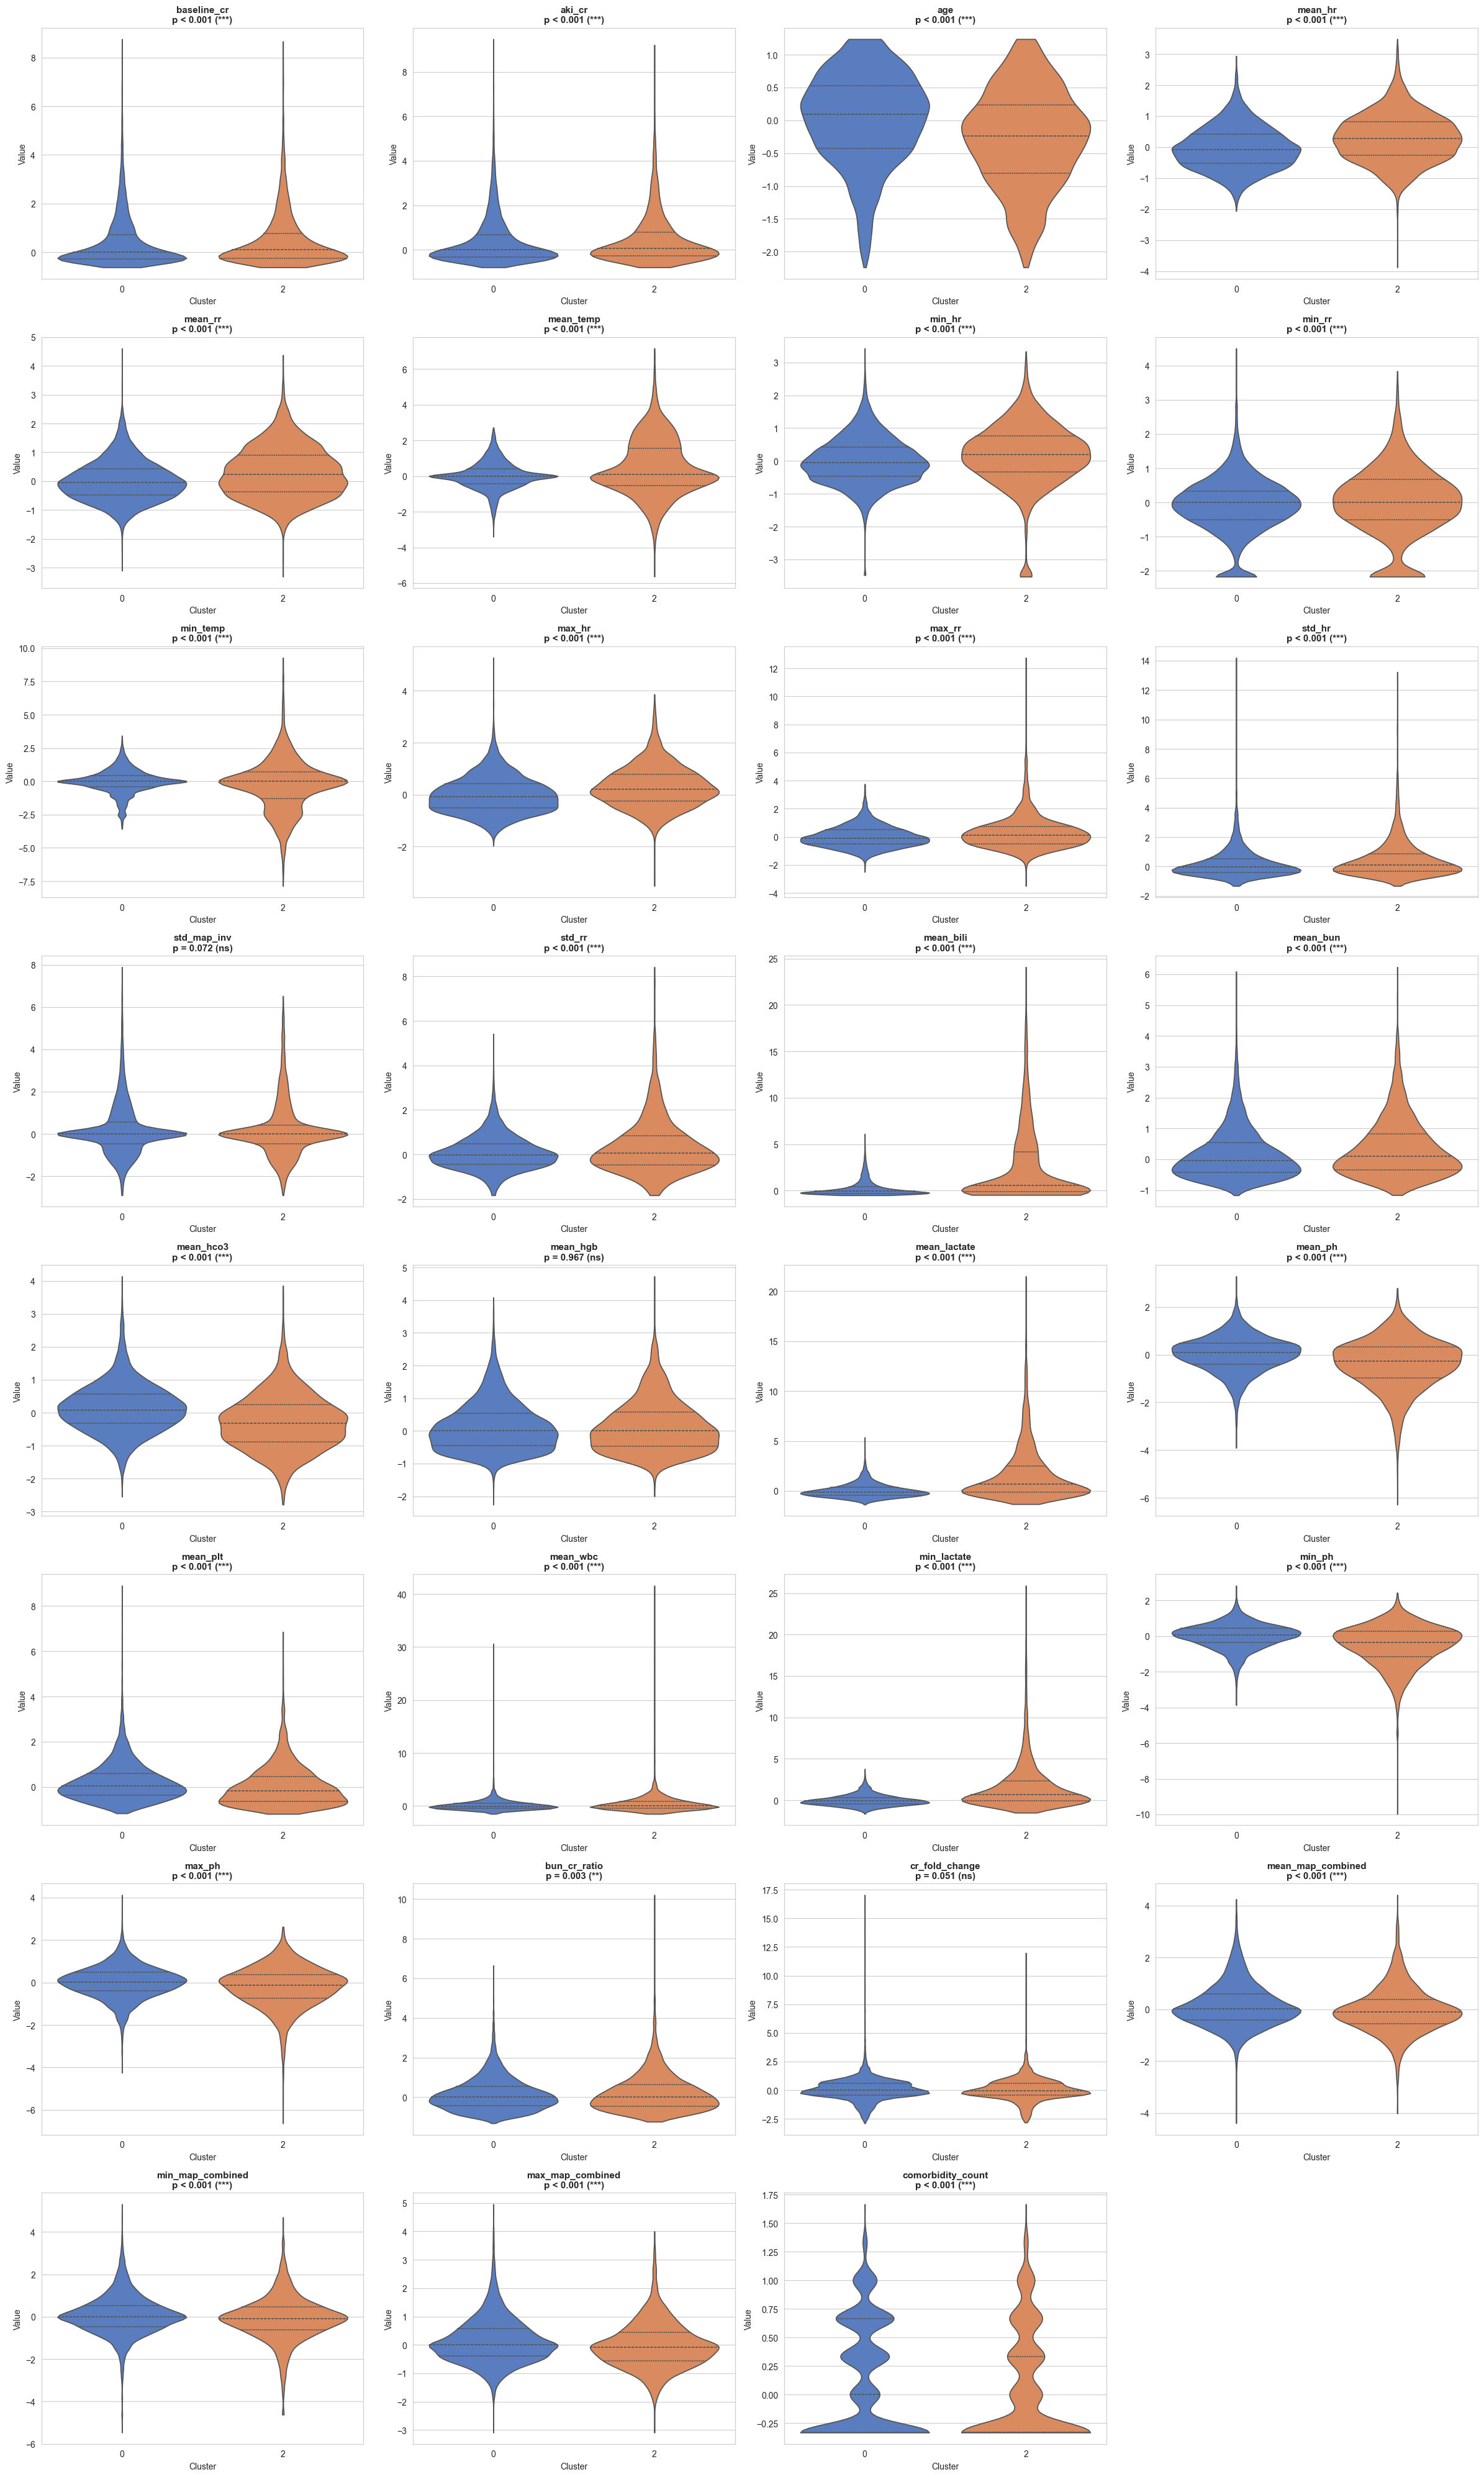


✅ Done! Visualized 31 continuous features.
Results saved to: ./output/continuous_features_violin_comparison.png


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

print("\n📈 STATISTICAL COMPARISON (CONTINUOUS VARIABLES ONLY)")
print("Generating violin plots for numerical distributions...\n" + "="*60)

# 1. Identify continuous features
# Exclude identifiers, target, and cluster labels
exclude_cols = ['stay_id', 'aki_time', 'aki_stage', 'cluster']
candidate_features = [f for f in full_data_filtered.columns if f not in exclude_cols]

# Filter: Only include features with more than 2 unique values (Heuristic for Continuous)
# This excludes binary flags (comorbidities, gender_M) and one-hot encoded categories.
continuous_features = [f for f in candidate_features if full_data_filtered[f].nunique() > 2]

# 2. Configure the grid
n_cols = 4
n_rows = (len(continuous_features) + n_cols - 1) // n_cols

# Create a figure scaled to the number of continuous features
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 5 * n_rows))
axes = axes.flatten()

# 3. Iterate through continuous features
for i, feature in enumerate(continuous_features):
    ax = axes[i]
    
    # Extract groups for Kruskal-Wallis statistical test
    groups = [full_data_filtered[full_data_filtered['cluster'] == c][feature].dropna() 
              for c in sorted(full_data_filtered['cluster'].unique())]
    
    # Perform test
    if all(len(g) > 0 for g in groups):
        h_stat, p_value = stats.kruskal(*groups)
        
        # Format P-value for plot title
        if p_value < 0.001: sig = 'p < 0.001 (***)'
        elif p_value < 0.01: sig = f'p = {p_value:.3f} (**)'
        elif p_value < 0.05: sig = f'p = {p_value:.3f} (*)'
        else: sig = f'p = {p_value:.3f} (ns)'
        
        # Create Violin Plot
        # cut=0: prevents the violin from showing values outside the observed range
        # inner='quartile': adds dashed lines for 25th, 50th, and 75th percentiles
        sns.violinplot(x='cluster', y=feature, data=full_data_filtered, 
                       ax=ax, palette='muted', cut=0, inner='quartile')
        
        ax.set_title(f'{feature}\n{sig}', fontweight='bold', fontsize=11)
    else:
        ax.set_title(f'{feature}\n(Insufficient Data)', color='red')
    
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Value')

# 4. Cleanup and Save
# Remove any empty subplots at the end of the grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("./output/continuous_features_violin_comparison.png", dpi=200, bbox_inches='tight')
plt.show()

print(f"\n✅ Done! Visualized {len(continuous_features)} continuous features.")
print(f"Results saved to: ./output/continuous_features_violin_comparison.png")

## 9. Feature Importance for Clustering


🎯 Feature Importance for Clustering

Training Random Forest to identify discriminating features...

Top 20 features distinguishing clusters:


,feature,importance
21,mean_bili,0.211399
29,min_lactate,0.143892
12,mean_temp,0.118854
25,mean_lactate,0.106137
15,min_temp,0.068812
30,min_ph,0.031101
23,mean_hco3,0.029986
20,std_rr,0.022724
17,max_rr,0.019868
11,mean_rr,0.018965


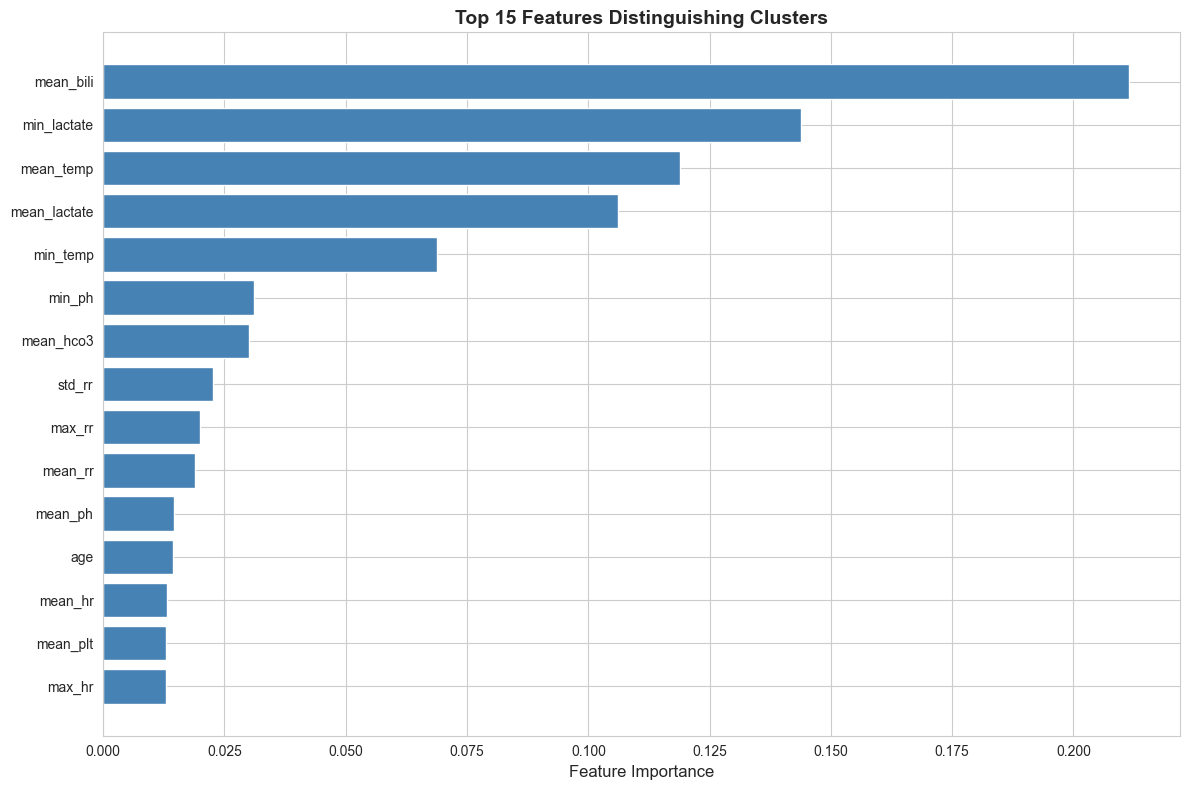


✓ Saved: ./clustering_output/result/feature_importance.png


In [11]:
print("\n🎯 Feature Importance for Clustering\n" + "="*60)

# Calculate feature importance using Random Forest
from sklearn.ensemble import RandomForestClassifier

# Keep only selected clusters
X_filtered = X[mask_valid]
labels_filtered = labels_final[mask_valid]


print("\nTraining Random Forest to identify discriminating features...")
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
# rf.fit(X, labels_final)
rf.fit(X_filtered, labels_filtered)

# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 20 features distinguishing clusters:")
display(feature_importance.head(20))

# Visualize top 15
fig, ax = plt.subplots(figsize=(12, 8))
top_features = feature_importance.head(15)
ax.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].values)
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Top 15 Features Distinguishing Clusters', fontweight='bold', fontsize=14)
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/feature_importance.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved: {RESULT_DIR}/feature_importance.png")

## 10. Cluster Heatmap


🔥 CLUSTER HEATMAP


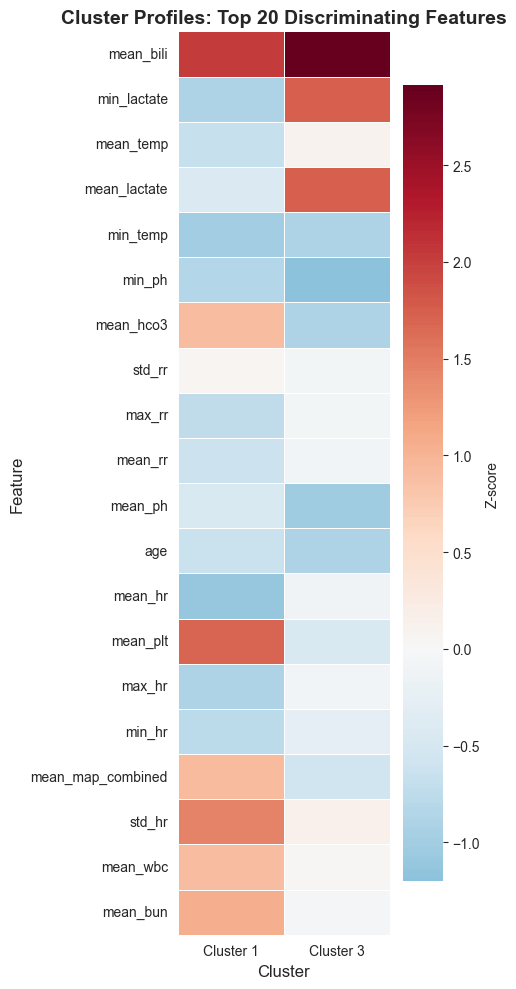

✓ Saved: ./clustering_output/result/cluster_heatmap.png


In [12]:
print("\n🔥 CLUSTER HEATMAP\n" + "="*60)

# Select top discriminating features
top_n_features = 20
top_feat_names = feature_importance.head(top_n_features)['feature'].values

# Calculate cluster centroids for these features
cluster_profiles = full_data_filtered.groupby('cluster')[top_feat_names].mean()

# Normalize for visualization (z-score)
from scipy.stats import zscore
cluster_profiles_norm = cluster_profiles.apply(zscore, axis=1)

# Create heatmap
fig, ax = plt.subplots(figsize=(5, 10))
sns.heatmap(cluster_profiles_norm.T, annot=False, cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Z-score'}, linewidths=0.5,
            xticklabels=[f'Cluster {i+1}' for i in full_data_filtered['cluster'].unique()],
            yticklabels=top_feat_names, ax=ax)
ax.set_title(f'Cluster Profiles: Top {top_n_features} Discriminating Features', 
             fontweight='bold', fontsize=14)
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)

plt.tight_layout()
plt.savefig(f"{RESULT_DIR}/cluster_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Saved: {RESULT_DIR}/cluster_heatmap.png")

## 11. Save Final Results

In [13]:
print("\n💾 SAVING FINAL RESULTS\n" + "="*60)

# Save cluster assignments with phenotype names
results = ids.copy()
results['cluster'] = labels_final

# Add clustering probabilities for GMM
if best_method_name == 'gmm':
    for i in range(OPTIMAL_K):
        results[f'prob_cluster_{i+1}'] = probs_gmm[:, i]
    results['cluster_confidence'] = max_probs

results.to_csv(f"{DATA_DIR}/cluster_assignments.csv", index=False)
print(f"✓ Saved: {DATA_DIR}/cluster_assignments.csv")

# Save full data with clusters
full_data.to_csv(f"{DATA_DIR}/aki_with_clusters.csv", index=False)
print(f"✓ Saved: {DATA_DIR}/aki_with_clusters.csv")

# Save cluster summary statistics
summary_stats = []
for cluster_id in range(OPTIMAL_K):
    cluster_data = full_data[full_data['cluster'] == cluster_id]
    
    stats_dict = {
        'cluster': cluster_id + 1,
        'n_patients': len(cluster_data),
        'percent': len(cluster_data) / len(full_data) * 100,
        'age_mean': cluster_data['age'].mean(),
        'age_std': cluster_data['age'].std(),
        'aki_stage_mean': cluster_data['aki_stage'].mean(),
        'stage_1_pct': (cluster_data['aki_stage'] == 1).mean() * 100,
        'stage_2_pct': (cluster_data['aki_stage'] == 2).mean() * 100,
        'stage_3_pct': (cluster_data['aki_stage'] == 3).mean() * 100,
    }
    
    # Add key clinical features if available
    if 'cr_fold_change' in cluster_data.columns:
        stats_dict['cr_fold_change_mean'] = cluster_data['cr_fold_change'].mean()
    if 'mean_map' in cluster_data.columns:
        stats_dict['map_mean'] = cluster_data['mean_map'].mean()
    if 'max_lactate' in cluster_data.columns:
        stats_dict['lactate_mean'] = cluster_data['max_lactate'].mean()
    
    summary_stats.append(stats_dict)

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv(f"{RESULT_DIR}/cluster_summary.csv", index=False)
print(f"✓ Saved: {RESULT_DIR}/cluster_summary.csv")

# Save clustering metrics
metrics_summary = pd.DataFrame({
    'metric': ['Method', 'Number of Clusters', 'Silhouette Score', 
               'Davies-Bouldin Index', 'Calinski-Harabasz Score'],
    'value': [best_method_name.upper(), OPTIMAL_K, 
              silhouette_score(X_for_clustering, labels_final),
              davies_bouldin_score(X_for_clustering, labels_final),
              calinski_harabasz_score(X_for_clustering, labels_final)]
})
metrics_summary.to_csv(f"{RESULT_DIR}/clustering_metrics.csv", index=False)
print(f"✓ Saved: {RESULT_DIR}/clustering_metrics.csv")


💾 SAVING FINAL RESULTS
✓ Saved: ./clustering_output/data/cluster_assignments.csv
✓ Saved: ./clustering_output/data/aki_with_clusters.csv
✓ Saved: ./clustering_output/result/cluster_summary.csv
✓ Saved: ./clustering_output/result/clustering_metrics.csv


## 12. Final Report

In [14]:
print("✅ CLUSTERING ANALYSIS COMPLETE!")
print("="*60)

print(f"\n📊 SUMMARY:")
print(f"   Method:              {best_method_name.upper()}")
print(f"   Number of clusters:  {OPTIMAL_K}")
print(f"   Total patients:      {len(full_data):,}")
print(f"   Silhouette score:    {silhouette_score(X_for_clustering, labels_final):.3f}")

print(f"\n🏥 IDENTIFIED PHENOTYPES:")

unique_labels = np.sort(np.unique(labels_final))

for idx, lbl in enumerate(unique_labels, start=1):
    n = (labels_final == lbl).sum()
    pct = n / len(labels_final) * 100
    print(f"   {idx}. Cluster {lbl:>3} ({n:5,} patients, {pct:5.1f}%)")


print(f"\n📁 OUTPUT FILES:")
print(f"   1. cluster_assignments.csv       - Patient-level cluster assignments")
print(f"   2. aki_with_clusters.csv         - Full dataset with clusters")
print(f"   3. cluster_summary.csv           - Cluster-level statistics")
print(f"   4. clustering_metrics.csv        - Validation metrics")
print(f"   5. Multiple visualization PNGs")

print(f"\n🎯 NEXT STEPS:")
print(f"   1. Clinical validation: Review phenotypes with domain experts")
print(f"   2. Outcome analysis: Compare mortality/dialysis/recovery by cluster")
print(f"   3. External validation: Test on eICU or other datasets")
print(f"   4. Predictive modeling: Build cluster-specific outcome models")

print("\n" + "="*60)

# Display final cluster summary
print("\n📋 CLUSTER SUMMARY TABLE:")
display(summary_df)


✅ CLUSTERING ANALYSIS COMPLETE!

📊 SUMMARY:
   Method:              GMM
   Number of clusters:  6
   Total patients:      15,394
   Silhouette score:    0.321

🏥 IDENTIFIED PHENOTYPES:
   1. Cluster   0 (11,402 patients,  74.1%)
   2. Cluster   1 (    1 patients,   0.0%)
   3. Cluster   2 (3,736 patients,  24.3%)
   4. Cluster   3 (    2 patients,   0.0%)
   5. Cluster   4 (    1 patients,   0.0%)
   6. Cluster   5 (  252 patients,   1.6%)

📁 OUTPUT FILES:
   1. cluster_assignments.csv       - Patient-level cluster assignments
   2. aki_with_clusters.csv         - Full dataset with clusters
   3. cluster_summary.csv           - Cluster-level statistics
   4. clustering_metrics.csv        - Validation metrics
   5. Multiple visualization PNGs

🎯 NEXT STEPS:
   1. Clinical validation: Review phenotypes with domain experts
   2. Outcome analysis: Compare mortality/dialysis/recovery by cluster
   3. External validation: Test on eICU or other datasets
   4. Predictive modeling: Build cluste

,cluster,n_patients,percent,age_mean,age_std,aki_stage_mean,stage_1_pct,stage_2_pct,stage_3_pct,cr_fold_change_mean
0,1,11402,74.067819,0.011506,0.703173,1.739607,57.560077,10.919137,31.520786,0.075253
1,2,1,0.006496,0.523810,NaN,3.000000,0.000000,0.000000,100.000000,-1.352554
2,3,3736,24.269196,-0.278105,0.743556,1.919165,47.430407,13.222698,39.346895,0.059749
3,4,2,0.012992,0.690476,0.168359,1.500000,50.000000,50.000000,0.000000,0.820460
4,5,1,0.006496,-0.809524,NaN,3.000000,0.000000,0.000000,100.000000,-1.386443
5,6,252,1.637001,-0.059524,0.713528,1.873016,49.603175,13.492063,36.904762,0.120001
